# AlexNet알레스넷

In [ ]:
pip install torchinfo

In [ ]:
#모델 요약 함수
information = torchinfo.summary(
    model,
    input_data
)

NameError: name 'torchinfo' is not defined

In [ ]:
#알레스넷 모델 불러오기 함수
model=torchvision.models.alexnet(
    weights="AlexNet_weights.IMAGENET1K_V1" #사전 학습된 가중치 매개변수 weights
)

NameError: name 'torchvision' is not defined

In [ ]:
#알레스넷 모델 구조 출력
from torchvision import models
from torchinfo import summary

model=models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1")
summary(model, (1, 3, 224, 224), device="cpu") #이 크기의 텐서 입력

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 78.0MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [ ]:
#클래스 정보 파일 불러오기
with open("/content/imagenet_classes.txt", "r") as file:
    classes = file.read().splitlines()

print(f"클래스 개수 : {len(classes)}")
print(f"첫 번째 클래스 레이블 : {classes[0]}")

클래스 개수 : 1000
첫 번째 클래스 레이블 : tench


In [ ]:
#이미지 데이터 전처리
import torch
from PIL import Image
from torchvision import models, transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize( #정규화 클래스
            mean=[0.485, 0.456, 0.406], #평균
            std=[0.229, 0.224, 0.225] #표준편차값 -> 이미지넷 데이터세트에서 사용된 이미지들의 평균과 표준편차값
        ),
    ]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

tensors = []
files = ["/content/airplane.jpg", "/content/bus.jpg"]
for file in files:
    image = Image.open(file)
    tensors.append(transform(image))

tensors = torch.stack(tensors)
print(f"입력 텐서의 크기 : {tensors.shape}")

입력 텐서의 크기 : torch.Size([2, 3, 224, 224])


In [ ]:
#알레스넷 모델 추론
import numpy as np
from torch.nn import functional as F


with torch.no_grad(): #기울기계산 비활성화
    outputs = model(tensors.to(device))
    probs = F.softmax(outputs, dim=-1) #전달된 텐서는 소프트맥스 함수로 값을 활성화함.
    top_probs, top_idxs = probs.topk(5) #가장 높은 텐서 다섯개 반환

top_probs = top_probs.detach().cpu().numpy() #가장 높은 텐서 다섯개 반환
top_idxs = top_idxs.detach().cpu().numpy() #top_probs가 해당하는 색인 값 의미
top_classes = np.array(classes)[top_idxs]

for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")
    for c, p in zip(cls, prob):
        print(f" - {c:<30} : {p * 100:>5.2f}%")
        #변형된 클래스와 해당 클래스 확률을 출력한다.
        # airliner와 warplne이 비행기와 유사한 클래스로 높게 예측됨.

/content/airplane.jpg 추론 결과
 - airliner                       : 66.83%
 - warplane                       : 20.12%
 - wing                           :  9.29%
 - space shuttle                  :  2.89%
 - missile                        :  0.38%
/content/bus.jpg 추론 결과
 - streetcar                      : 60.25%
 - trolleybus                     : 37.99%
 - minibus                        :  1.54%
 - passenger car                  :  0.17%
 - recreational vehicle           :  0.03%


# VGG

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


hyperparams = { #하이퍼파라미터 설정
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),#이미지 크기를 256 X 256로 조절하고
            transforms.CenterCrop(224), #224 X 224 크기의 이미지로 중앙 자르기 수행
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0/255.0, 1.0/255.0, 1.0/255.0]  #표준편차로 정규화 적용
            )
        ]
    )
}
#이미지 폴더 데이터세트 클래스와 데이터로더를 통해 데이터를 불러온다.
train_dataset = ImageFolder("/content/drive/MyDrive/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/drive/MyDrive/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

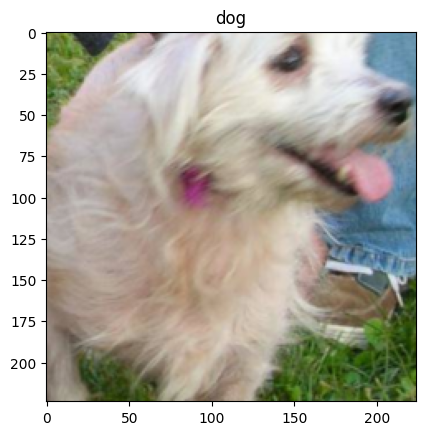

In [ ]:
#데이터시각화 - 몇 개의 샘플을 시각화해 확인해 본다.
import numpy as np
from matplotlib import pyplot as plt


mean=[0.48235, 0.45882, 0.40784]
std=[1.0/255.0, 1.0/255.0, 1.0/255.0]

images, labels = next(iter(train_dataloader)) #iter와 next 메서드를 통해 첫 번째 배치의 이미지와 레이블을 추출한다.
for image, label in zip(images, labels):
    image = image.numpy().transpose((1, 2, 0)) #numpy 메서드를 통해 ndarray 배열로 변경하고 transpose 메서드로 축의 순서 변경
    #[H, W, C]의 순서로 변형하기 위해 [1, 2, 0]으로 설정한다.
    image = ((std * image + mean) * 255).astype(np.uint8)
    # 반대의 순서로 연산을 적용한다. -> #이미지에 표준편차를 곱한 후, 평균값을 더한다.
    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)]) #int형식으로 변환한 다음 데이터세트의 classes 메서드로 레이블 매핑하기
    plt.show()
    break

In [ ]:
#vgg-16 모델 불러오기 및 계층구조 출력
from torchvision import models
model=models.vgg16(
    weights="VGG16_Weights.IMAGENET1K_V1" #사전 학습된 가중치 매개변수 weights

)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#VGG-16 미세조정
from torch import nn

model.classifier[6] = nn.Linear(4096, len(train_dataset.classes)) #분류기의 여섯 번째 선형 계층에 접근할 수 있다.
# 출력 데이터의 차원 크기에 train_dataset의 클래스 개수를 입력한다

In [ ]:
# VGG-16 모델 학습하기
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[1.0 / 255.0, 1.0 / 255.0, 1.0 / 255.0],
            ),
        ]
    ),
}

#이미지 폴더 데이터세트 클래스와 데이터로더를 통해 데이터를 불러온다.
train_dataset = ImageFolder("/content/drive/MyDrive/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("/content/drive/MyDrive/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())
        #비교 함수(torch.eq)로 테스트 데이터세트의 레이블(classes)과 모델 예측 결과(outpurts_classes)를 비교
        #전체 데이터 개수를 나눠 테스트 데이터세트에 대한 예측 정확도를 계산한다.

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")
# acuuracy 변수에 예측이 성공한 개수가 저장됐으므로
# 전체 데이터 개수를 나눠 테스트 데이터세트에 대한 예측 정확도를 계산한다.




Epoch :    1, Cost : 4.939
Epoch :    2, Cost : 1.106
Epoch :    3, Cost : 1.470
Epoch :    4, Cost : 0.005
Epoch :    5, Cost : 0.090
acc@1 : 80.00%


# ResNet

In [ ]:
#기본 블록
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1): #입력 특징 맵의 차원 수(inplanes), 출력 특징 맵의 차원 수 (planes)
        super().__init__()
        self.conv1 = nn.Conv2d( # 첫 번째 합성곱 레이어 정의
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes) # 첫 번째 배치 정규화 레이어 정의
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d( # 두 번째 합성곱 레이어 정의
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # Shortcut 경로 정의
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False # 1x1 합성곱 레이어 정의
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x): # 순전파 메서드 정의
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) #잔차 연결을 통해 입력값과 출력값을 더한 다음 활성화된다.
        out = self.relu(out)
        return out

In [ ]:
#병목 블록
class BottleneckBlock(nn.Module):
    expansion = 4 # 더 많은 확장변수 사용

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d( #세번째 합성곱 연산
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
#레즈넷 모델 클래스
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),

            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1) #레즈넷의 스테이지 시작점은 64차원이다.
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)  # 합성곱 계층의 첫 간격을 2로 사용
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes) # 최종 완전연결 계층 정의

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1): #두번째 블록부터는 블록수 -1 만큼 반복해 간격을 1로 생성해 전달한다.
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
pip install torchinfo

In [ ]:
#레즈넷 모델 비교
from torchvision import models
from torchinfo import summary


resnet18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 1000)
resnet101 = ResNet(BottleneckBlock, [3, 4, 23, 3], 1000)
resnet152 = ResNet(BottleneckBlock, [3, 8, 36, 3], 1000)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0) #직접 구현한 ResNet-34
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0) #토치비전에서 제공하는 사전학습된 ResNet-34


print(resnet34_info.total_params)
print(torch_model_info.total_params) #모델에서 사용된 총 매개변수 개수 같음

21797672
21797672


#CAM

In [ ]:
#ResNet-18 모델 특징 추출
from torch import nn
from torchvision import models

model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval() #평가 모드로 변경가능
# 마지막 계층을 제외한 특징 추출 방법을 보여줌.
features = nn.Sequential(*list(model.children())[:-2]) #모듈 클래스에 포함된 하위 모듈을 반환한다.

In [ ]:
#특징 맵과 가중치 추출
from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("/content/drive/MyDrive/airplane (1).jpg")
target = transform(image).unsqueeze(0)

output = model(target)
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
#가중치에 대한 클래스 영향도를 확인 -> 차원 [512] #차원 변경 메서드reshape로 확장한다.
features_output = features(target).squeeze()
#[1, 512, 7, 7] 의 차원 형태로 반환, 배치크기를 의마하는 첫 번째 차원은 불필요하므로 스퀴즈 메서드로 제거한다.

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [ ]:
#클래스 활성화 맵 생성
import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0) #합 연산을 통해 (7, 7) 크기로 변경한다.
cam = F.interpolate( #보간 함수로 입력 이미지 크기와 동일한 크기로 변경한다.
    input=cam.unsqueeze(0).unsqueeze(0), #차원 확장하고 cam을 이미지 크기와 동일한 크기로 벼ㅕㄴ경한다.
    size=(image.size[1], image.size[0]),
    mode="bilinear", #이중 선형 보간을 통해 부드럽게 확장한다.
).squeeze().detach().numpy()

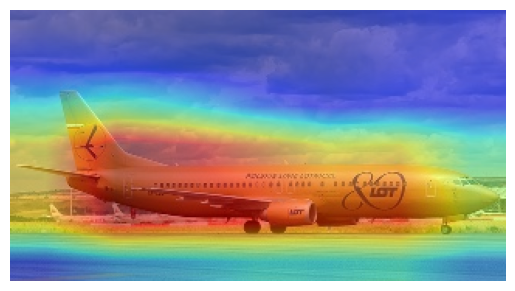

In [ ]:
#클래스 활성화 맵 시각화
import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()
# 붉은색 계열로 표시된 곳이 가장 많은 영향을 준 영역이다.

In [ ]:
#클래스 활성화 맵 생성 (nearest 사용해보기)
import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0) #합 연산을 통해 (7, 7) 크기로 변경한다.
cam = F.interpolate( #보간 함수로 입력 이미지 크기와 동일한 크기로 변경한다.
    input=cam.unsqueeze(0).unsqueeze(0), #차원 확장하고 cam을 이미지 크기와 동일한 크기로 변경한다.
    size=(image.size[1], image.size[0]),
    mode="nearest", #이중 보간을 사용해 7x7 블로의 형태로 확인할 수 있음
).squeeze().detach().numpy()

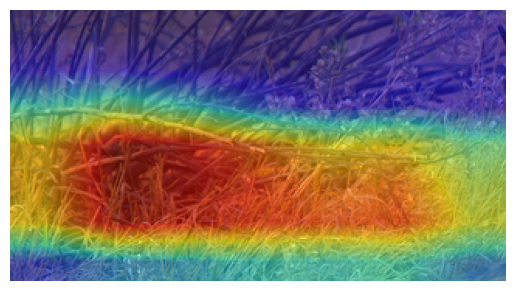

In [ ]:
#클래스 활성화 맵 시각화
import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

# Grad-CAM

In [1]:
# 순전파와 역전파 후크 등록
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub) #합성곱 계층을 확인하기 위한 main, sub를 받아온다. 후크를 등록함.

    def register_hook(self, main, sub):
        for name, module in self.model.named_children(): #named_childeren 메서드는 모듈의 이름과 모듈을 반환
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook) #순방향 후크 등록
                        sub_module.register_full_backward_hook(self.backward_hook) #역방향 후크 등록

    def forward_hook(self, module, input, output):
        self.feature_map = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]



In [5]:
#Grad-CAM 생성
def __call__(self, x):
        output = self.model(x)

        index = output.argmax(axis=1) # 출력을 바탕으로 가장 높은 값을 갖는 클래스의 인덱스를 찾습니다
        one_hot = torch.zeros_like(output) # 출력과 같은 크기의 0으로 채워진 텐서를 생성합니다.
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True) # one-hot 벡터를 이용해 역전파를 수행합니다.

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True) # 특징 맵의 그래디언트를 평균하여 a_k를 계산합니다.
        grad_cam = torch.sum(a_k * self.feature_map, dim=1) # 특징 맵과 a_k를 곱해 Grad-CAM을 생성합니다.
        grad_cam = torch.relu(grad_cam)
        return grad_cam

In [9]:
# Grad-CAM 시각화
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt

# 이미지를 전처리하기 위한 변환 설정
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # 이미지를 텐서로 변환
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "/content/drive/MyDrive/airplane (1).jpg", "/content/drive/MyDrive/bus (1).jpg",
    "/content/drive/MyDrive/pet/test/dog/dog.4001.jpg", "/content/drive/MyDrive/african_hunting_dog.jpg"
]
images, tensors = [], []
# 각 파일을 열어 전처리 후 리스트에 추가
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors) # 텐서들을 하나의 텐서로 병합

# GradCAM 모델을 설정
model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
# GradCAM을 사용하여 주목 영역을 계산
grad_cams=model(Tensors)

# 각 이미지를 순회하면서 GradCAM 시각화 수행
for idx, image in enumerate(images):
    grad_cam = F.interpolate( # GradCAM 출력을 원래 이미지 크기로 보간
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off") #축 제거
    plt.show()

NameError: name 'Tensors' is not defined